# Animal Classifier Model

In [1]:
!nvidia-smi # check if cuda available

Thu Jun 20 08:16:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Importing Libraries


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# kaggle.json

* kaggle.json contains the link of the dataset used to train model

`{
    "username": "shauryadusht",
    "key": "kaggle datasets download -d likhon148/animal-data"
}`


In [4]:
# Step 1: Upload `kaggle.json` to Colab
from google.colab import files
files.upload()

# Step 2: Move `kaggle.json` to the correct location and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Install Kaggle package
!pip install kaggle

# Step 4: Download the dataset
!kaggle datasets download -d likhon148/animal-data

# Step 5: Unzip the dataset
import zipfile
import os

# Create a directory for the dataset
os.makedirs("animal_data", exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile('animal-data.zip', 'r') as zip_ref:
    zip_ref.extractall('animal_data')

# Step 6: Verify the extraction
os.listdir('animal_data')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/likhon148/animal-data
License(s): MIT
 96% 35.0M/36.3M [00:03<00:00, 18.5MB/s]
100% 36.3M/36.3M [00:03<00:00, 11.9MB/s]


['animal_data']

## Define transformations

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])

## Load dataset

In [6]:
data_dir = r'./animal_data/animal_data'
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

## Split dataset and creating data loader

In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Load pre-trained model

In [8]:
model = models.resnet50(weights=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


## Define loss function and optimizer


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training and evaluation functions


In [10]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), 100 * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), 100 * correct / total


## Training loop

In [11]:
from tqdm import tqdm
import time

train_losses = []
test_losses = []

epochs = 5
for epoch in range(epochs):
    tqdm.write(f'Epoch: {epoch+1}')

    start_time = time.time()  # Start timer

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    tqdm.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    tqdm.write(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time
    tqdm.write(f'Time taken for epoch {epoch+1}: {elapsed_time:.2f} seconds')

Epoch: 1
Train Loss: 0.9723, Train Accuracy: 80.00%
Test Loss: 0.2299, Test Accuracy: 95.37%
Time taken for epoch 1: 29.37 seconds
Epoch: 2
Train Loss: 0.1159, Train Accuracy: 97.56%
Test Loss: 0.0807, Test Accuracy: 97.69%
Time taken for epoch 2: 23.92 seconds
Epoch: 3
Train Loss: 0.0693, Train Accuracy: 98.52%
Test Loss: 0.1004, Test Accuracy: 96.92%
Time taken for epoch 3: 24.06 seconds
Epoch: 4
Train Loss: 0.0455, Train Accuracy: 99.16%
Test Loss: 0.1009, Test Accuracy: 95.63%
Time taken for epoch 4: 26.91 seconds
Epoch: 5
Train Loss: 0.0337, Train Accuracy: 99.49%
Test Loss: 0.0751, Test Accuracy: 97.43%
Time taken for epoch 5: 27.73 seconds


## Plotting the train and test losses

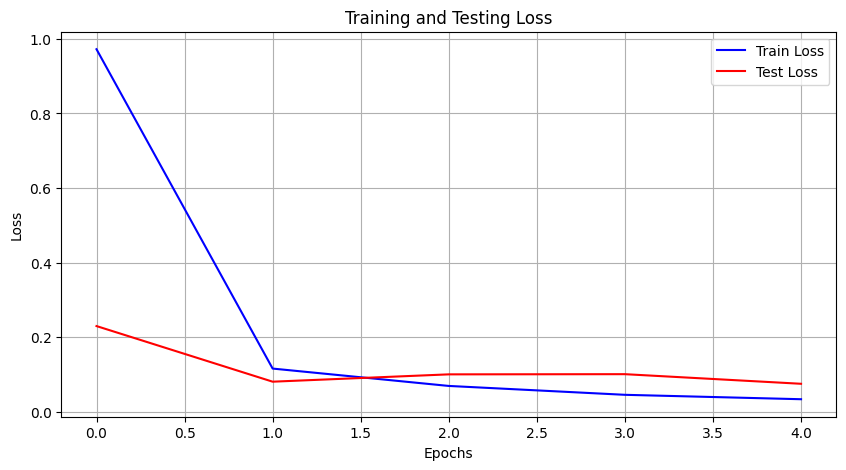

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

The model made using the data set has accuracy as following :
* Train Accuracy : 99.49%
* Test Accuracy : 97.43%

In [13]:
# Save the model in colab
torch.save(model.state_dict(), 'animal_classifier.pth')

In [14]:
# Download the model to local device
from google.colab import files
files.download('animal_classifier.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>